# Abstract

Theme:
- BTC transaction values

Research Questions:
- Is there any difference of BTC transaction values between its time such as AM/PM or Even/Odd hours?

Methods:
- Conduct frequentist statistical analysis on the difference of BTC transaction values between the below viewpoints:
  - AM vs PM hours such as 0-12 and 12-24
  - Even vs Odd hours such as 0,2,4,,, and 1,3,5,,,

Data:
- Daily BTC transactions from 2022-02 to 2022-04

Results and Conclusions:
- The BTC transaction values during PM hours are larger than those of AM hours statistically significantly.
- The BTC transaction values during odd hours are not larger than those of even hours statistically significantly.

Ref:
- http://nipper.work/btc/index.php?market=bitFlyer&coin=BTCJPY&periods=3600&after=1643673600&before=1651363140
- https://github.com/just4jc/DataCamp-3/blob/master/07-statistical-thinking-in-python-(part-2)/3-introduction-to-hypothesis-testing/permutation-test-on-frog-data.py


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy import stats

pd.options.display.float_format = '{:,.2f}'.format
path = "../data"

In [2]:
# Read the sample data
df = pd.read_csv(path + "/01_raw/btc_202202_202204_per1h.csv", header=None, names=["datetime", "open", "close", "low", "high", "volumes"], parse_dates=['datetime'])

In [3]:
# Calculate the transaction values by multipling volumes by the average prices during the hour
df["transaction_values"] = df["volumes"] * (df["low"] + df["high"])/2

In [11]:
# Generate two arrays: am hours transaction values and pm hours transaction values
am_hours_arr = df[df["datetime"].dt.hour < 12]["transaction_values"].values
pm_hours_arr = df[df["datetime"].dt.hour >= 12]["transaction_values"].values

print(f"AM hours transaction values: {np.mean(am_hours_arr)}, PM hours transaction values: {np.mean(pm_hours_arr)}")

AM hours transaction values: 398815143.1690035, PM hours transaction values: 461020354.90046513


From the above sample comparisons, the mean of pm hours transaction values is a bit larger than that of am hours transaction values?

In [12]:
# Generate two arrays: even hours transaction values and odd hours transaction values
even_hours_arr = df[df["datetime"].dt.hour %2 == 0]["transaction_values"].values
odd_hours_arr = df[df["datetime"].dt.hour %2 != 0]["transaction_values"].values

print(f"Even hours transaction values: {np.mean(even_hours_arr)}, Odd hours transaction values: {np.mean(odd_hours_arr)}")

Even hours transaction values: 423445570.65375066, Odd hours transaction values: 436389927.4157179


From the above sample comparisons, the mean of odd hours transaction values is a bit larger than that of even hours transaction values?

# Create functions to conduct statistical tests

In [18]:
def permutate_sample(s1, s2):
    """Generate a permutation sample from two data sets."""

    # Concatenate the data sets: concat
    concat = np.concatenate((s1, s2))

    # Permute the concatenated array: permuted
    permuted = np.random.permutation(concat)

    # Split the permuted array into two: perm1, perm2
    perm1 = permuted[:len(s1)]
    perm2 = permuted[len(s1):]

    return perm1, perm2

def draw_perm_reps(s1, s2, func, size=1):
    """Generate multiple permutation replicates."""

    # Initialize array of replicates: perm_replicates
    perm_reps = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        perm1, perm2 = permutate_sample(s1, s2)

        # Compute the test statistic
        perm_reps[i] = func(perm1, perm2)

    return perm_reps

def diff_of_means(s1, s2):
    """Difference in means of two arrays."""

    # The difference of means of data_1, data_2: diff
    diff = np.mean(s1) - np.mean(s2)

    return diff

# AM vs PM hours

## Check the distributions

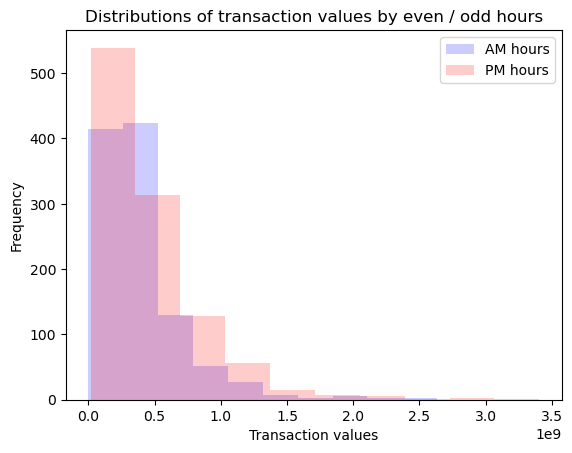

In [13]:
fig, ax1 = plt.subplots()

ax1.hist(am_hours_arr, color="b", alpha=0.2)
ax1.hist(pm_hours_arr, color="r", alpha=0.2)

ax1.set_xlabel("Transaction values")
ax1.set_ylabel("Frequency");
ax1.set_title("Distributions of transaction values by even / odd hours")
ax1.legend(["AM hours", "PM hours"]);

It seems tough to compare the distributions by eyeballs.

In [15]:
d = np.mean(pm_hours_arr) - np.mean(am_hours_arr)
d

62205211.731461644

How much rare is this sample of difference when we assume these two samples come from the same pupulation distribution?

## Conduct permutation test on the two series: AM hours and PM hours
- H0: PM hours transaction values == AM hours transaction values
- H1: PM hours transaction values > AM hours transaction values

p-value = 0.0
62205211.731461644


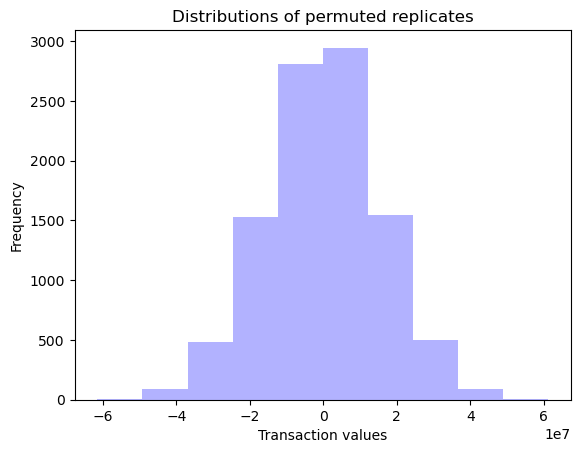

In [17]:
# Compute difference of mean transaction values: actual_diff_means
actual_diff_means = diff_of_means(pm_hours_arr, am_hours_arr)

# Draw 10,000 permutation replicates: perm_reps
perm_reps = draw_perm_reps(pm_hours_arr, am_hours_arr, diff_of_means, size=10000)

# Compute p-value: p
p = np.sum(perm_reps >= actual_diff_means) / len(perm_reps)

# Print the result
print('p-value =', p)

fig, ax1 = plt.subplots()

ax1.hist(perm_reps, color="b", alpha=0.3)

ax1.set_xlabel("Transaction values")
ax1.set_ylabel("Frequency");
ax1.set_title("Distributions of permuted replicates");
print(actual_diff_means)

## 2標本t検定 (Welch検定)

In [19]:
print(stats.ttest_ind(pm_hours_arr, am_hours_arr, equal_var = False, alternative = "greater", permutations=None, random_state=0))

Ttest_indResult(statistic=3.997299417759453, pvalue=3.316511764391856e-05)


In [20]:
print(stats.ttest_ind(pm_hours_arr, am_hours_arr, equal_var = False, alternative = "greater", permutations=10000, random_state=0))

Ttest_indResult(statistic=3.997299417759453, pvalue=0.0)


## Conclusion: 
Transaction values during PM hours are larger than those of AM hours statistically significantly at the 0.1 significance level. 
Therefore, we reject H0.

# Even vs Odd hours

## Check the distributions

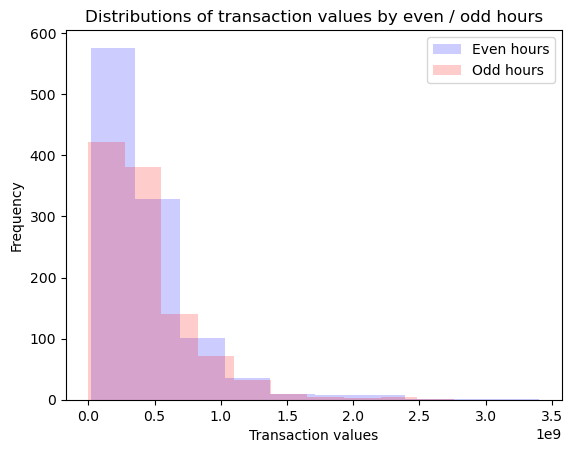

In [21]:
fig, ax1 = plt.subplots()

ax1.hist(even_hours_arr, color="b", alpha=0.2)
ax1.hist(odd_hours_arr, color="r", alpha=0.2)

ax1.set_xlabel("Transaction values")
ax1.set_ylabel("Frequency");
ax1.set_title("Distributions of transaction values by even / odd hours")
ax1.legend(["Even hours", "Odd hours"]);

It seems tough to compare the distributions by eyeballs.

In [23]:
d = np.mean(odd_hours_arr) - np.mean(even_hours_arr)
d

12944356.761967242

How much rare is this sample of difference when we assume these two samples come from the same pupulation distribution?

## Conduct permutation test on the two series: Even hours and Odd hours
- H0: Odd hours transaction values == Even hours transaction values
- H1: Odd hours transaction values > Even hours transaction values

p-value = 0.2016
12944356.761967242


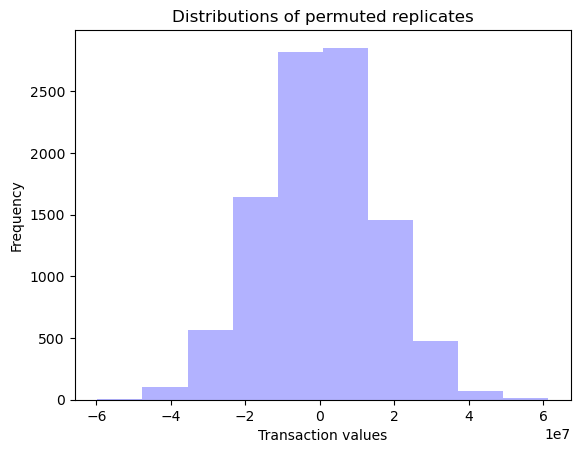

In [24]:
# Compute difference of mean transaction values: actual_diff_means
actual_diff_means = diff_of_means(odd_hours_arr, even_hours_arr)

# Draw 10,000 permutation replicates: perm_reps
perm_reps = draw_perm_reps(odd_hours_arr, even_hours_arr, diff_of_means, size=10000)

# Compute p-value: p
p = np.sum(perm_reps >= actual_diff_means) / len(perm_reps)

# Print the result
print('p-value =', p)

fig, ax1 = plt.subplots()

ax1.hist(perm_reps, color="b", alpha=0.3)

ax1.set_xlabel("Transaction values")
ax1.set_ylabel("Frequency");
ax1.set_title("Distributions of permuted replicates");
print(actual_diff_means)

## 2標本t検定 (Welch検定)

In [25]:
print(stats.ttest_ind(odd_hours_arr, even_hours_arr, equal_var = False, alternative = "greater", permutations=None, random_state=0))

Ttest_indResult(statistic=0.8288394869314462, pvalue=0.20364399848787262)


In [26]:
print(stats.ttest_ind(odd_hours_arr, even_hours_arr, equal_var = False, alternative = "greater", permutations=10000, random_state=0))

Ttest_indResult(statistic=0.8288394869314462, pvalue=0.2114)


## Conclusion: 
Transaction values during Odd hours are not larger than those of Even hours statistically significantly at the 0.1 significance level. 

Therefore, we accept H0.